# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.style.use('dark_background')

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

from google.cloud import bigquery
from google_auth_oauthlib import flow

from pmdarima import auto_arima

# Visualizations

In [2]:
df = pd.read_csv(os.path.join('data','prep_cov.csv'))

In [3]:
df.loc[:,'date'] = pd.to_datetime(df['date'])

In [4]:
first_day = min(df['date'])

In [5]:
last_day = max(df['date'])

## Worldwide

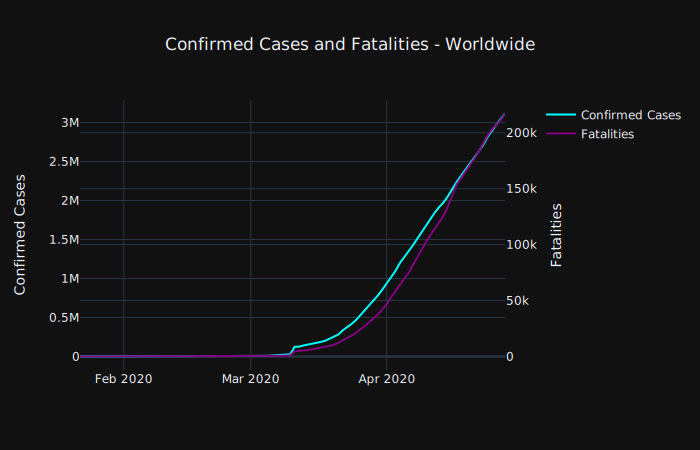

In [6]:
info_world = pd.DataFrame(df.groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=info_world.date, y=info_world.confirmed, name='Confirmed Cases', line=dict(color='cyan')))
fig.add_trace(go.Scatter(x=info_world.date, y=info_world.deaths, name='Fatalities', line=dict(color='purple')), secondary_y=True)

fig.update_yaxes(title_text="Confirmed Cases", secondary_y=False)
fig.update_yaxes(title_text="Fatalities", secondary_y=True)
fig.update_layout(title_text='Confirmed Cases and Fatalities - Worldwide', title_x=0.5)
fig.show('svg')

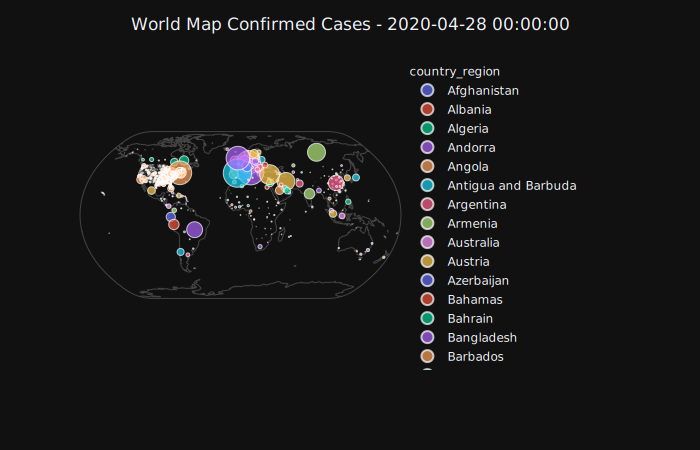

In [9]:
df_country = df[df['date'] == max(df['date'])].copy()
fig = px.scatter_geo(df_country,
                     lat='latitude', lon='longitude', color="country_region",
                     hover_name="country_region", size="confirmed",
                     projection="natural earth")
fig.update_layout(title='World Map Confirmed Cases - {}'.format(max(df['date'])), title_x=0.5)
fig.show('svg')

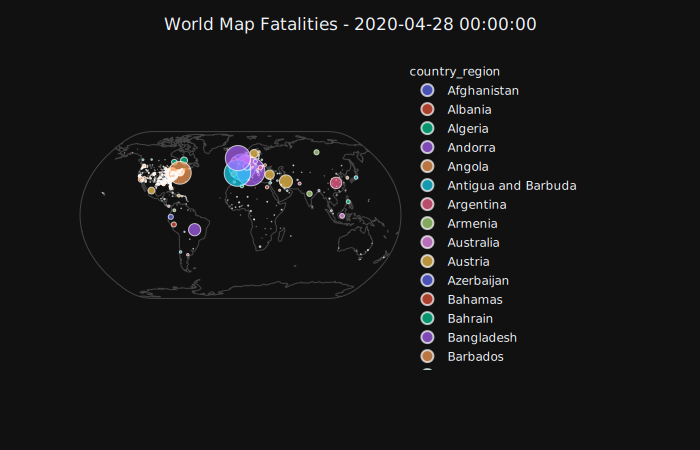

In [10]:
fig = px.scatter_geo(df_country,
                     lat='latitude', lon='longitude', color="country_region",
                     hover_name="country_region", size="deaths",
                     projection="natural earth")#,animation_frame="date")
fig.update_layout(title='World Map Fatalities - {}'.format(max(df['date'])), title_x=0.5)
fig.show('svg')

## Top 10 countries - Confirmed Cases

In [11]:
topCountriesConfCases = pd.DataFrame(df[df['date'] == last_day].groupby(['country_region'])['confirmed'].sum()).reset_index().sort_values(by='confirmed', ascending=False).reset_index(drop=True).loc[:10,'country_region'].values

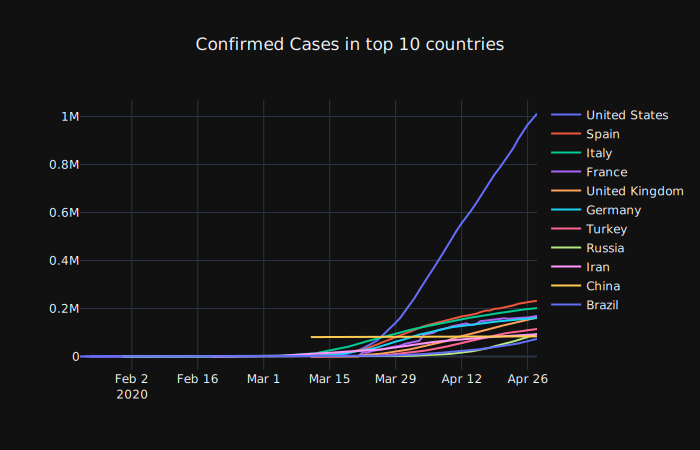

In [12]:
fig = go.Figure()
for country in topCountriesConfCases:
    info_country = pd.DataFrame(df[df['country_region'] == country].groupby('date')['confirmed'].sum()).reset_index().sort_values(by='date')
    fig.add_trace(go.Scatter(x=info_country.date, y=info_country.confirmed, name=country))
fig.update_layout(title_text='Confirmed Cases in top 10 countries', title_x=0.5)
fig.show('svg')

## Top 10 countries - New Cases

In [13]:
df_confCases = pd.DataFrame(df.groupby(['date','country_region'])['confirmed'].sum()).reset_index().sort_values(by=['country_region','date'])

In [14]:
for country in df_confCases['country_region'].unique():
    df_confCases.loc[df_confCases['country_region'] == country,'NewCases'] = np.append(0, np.diff(df_confCases.loc[df_confCases['country_region'] == country,'confirmed']))

In [15]:
topCountriesNewCases = df_confCases[df_confCases['date'] == last_day].sort_values(by='NewCases', ascending=False).reset_index(drop=True).loc[:10,'country_region'].values

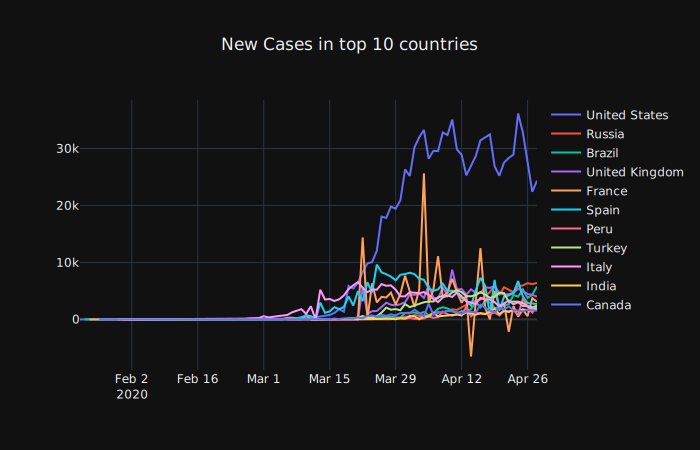

In [16]:
fig = go.Figure()
for country in topCountriesNewCases:
    info_country = df_confCases[df_confCases['country_region'] == country]
    fig.add_trace(go.Scatter(x=info_country.date, y=info_country.NewCases, name=country))
fig.update_layout(title_text='New Cases in top 10 countries', title_x=0.5)
fig.show('svg')

## Top 10 countries - Fatalities

In [17]:
topCountriesdeaths = pd.DataFrame(df[df['date'] == last_day].groupby(['country_region'])['deaths'].sum()).reset_index().sort_values(by='deaths', ascending=False).reset_index(drop=True).loc[:10,'country_region'].values

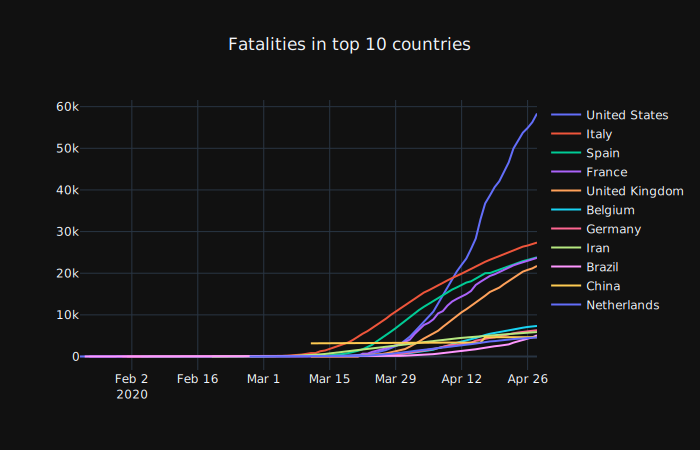

In [18]:
fig = go.Figure()
for country in topCountriesdeaths:
    info_country = pd.DataFrame(df[df['country_region'] == country].groupby('date')['deaths'].sum()).reset_index().sort_values(by='date')
    fig.add_trace(go.Scatter(x=info_country.date, y=info_country.deaths, name=country))
fig.update_layout(title_text='Fatalities in top 10 countries', title_x=0.5)
fig.show('svg')

## Top 10 countries - New deaths

In [19]:
df_fatalities = pd.DataFrame(df.groupby(['date','country_region'])['deaths'].sum()).reset_index().sort_values(by=['country_region','date'])

In [20]:
for country in df_fatalities['country_region'].unique():
    df_fatalities.loc[df_fatalities['country_region'] == country,'Newdeaths'] = np.append(0, np.diff(df_fatalities.loc[df_fatalities['country_region'] == country,'deaths']))

In [21]:
topCountriesNewdeaths = df_fatalities[df_fatalities['date'] == last_day].sort_values(by='Newdeaths', ascending=False).reset_index(drop=True).loc[:10,'country_region'].values

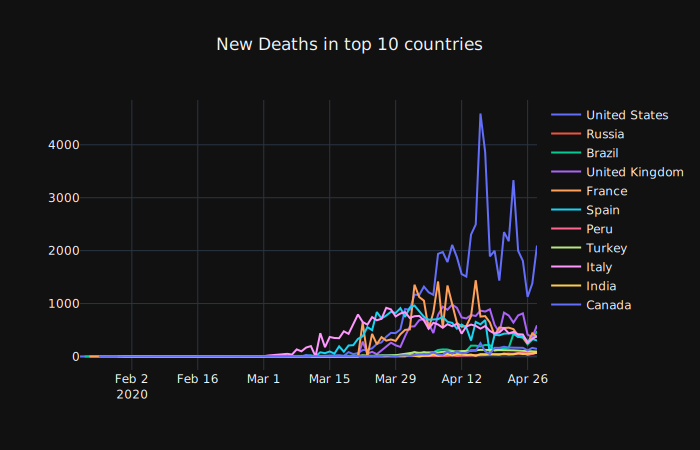

In [22]:
fig = go.Figure()
for country in topCountriesNewCases:
    info_country = df_fatalities[df_fatalities['country_region'] == country]
    fig.add_trace(go.Scatter(x=info_country.date, y=info_country.Newdeaths, name=country))
fig.update_layout(title_text='New Deaths in top 10 countries', title_x=0.5)
fig.show('svg')

## By Country

In [23]:
list_countries = list(df['country_region'].unique())

In [24]:
def plot_by_country(info):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    country = list_countries[0]
    
    if info == 'new cases':
        fig.add_trace(go.Scatter(x=pd.DataFrame(df[df['country_region'] == country].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').date,
                         y=np.append(0, np.diff(pd.DataFrame(df[df['country_region'] == country].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').confirmed)),
                         name='New Cases', line=dict(color='tomato'), visible=True))
        updatemenu=[]
        buttons=[]

        # button with one option for each dataframe
        for c in list_countries:
            buttons.append(dict(method='restyle',
                                label=c,
                                visible=True,
                                args=[{'y':[np.append(0, np.diff(pd.DataFrame(df[df['country_region'] == c].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').confirmed))],
                                       'x':[pd.DataFrame(df[df['country_region'] == c].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').date],
                                       'type':'scatter'}, [0]],
                                )
                          )
        
    elif info == 'new fatalities':
        fig.add_trace(go.Scatter(x=pd.DataFrame(df[df['country_region'] == country].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').date,
                         y=np.append(0, np.diff(pd.DataFrame(df[df['country_region'] == country].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').deaths)),
                         name='New Fatalities', line=dict(color='tomato'), visible=True))
        updatemenu=[]
        buttons=[]

        # button with one option for each dataframe
        for c in list_countries:
            buttons.append(dict(method='restyle',
                                label=c,
                                visible=True,
                                args=[{'y':[np.append(0, np.diff(pd.DataFrame(df[df['country_region'] == c].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').deaths))],
                                       'x':[pd.DataFrame(df[df['country_region'] == c].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').date],
                                       'type':'scatter'}, [0]],
                                )
                          )
    else:
        fig.add_trace(go.Scatter(x=pd.DataFrame(df[df['country_region'] == country].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').date,
                         y=pd.DataFrame(df[df['country_region'] == country].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date')[info],
                         name=info, line=dict(color='cyan'), visible=True))
        updatemenu=[]
        buttons=[]

        # button with one option for each dataframe
        for c in list_countries:
            buttons.append(dict(method='restyle',
                                label=c,
                                visible=True,
                                args=[{'y':[pd.DataFrame(df[df['country_region'] == c].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date')[info]],
                                       'x':[pd.DataFrame(df[df['country_region'] == c].groupby('date')[['confirmed','deaths']].sum()).reset_index().sort_values(by='date').date],
                                       'type':'scatter'}, [0]],
                                )
                          )
    # some adjustments to the updatemenus
    updatemenu=[]
    your_menu=dict()
    updatemenu.append(your_menu)

    updatemenu[0]['buttons']=buttons
    updatemenu[0]['direction']='down'
    updatemenu[0]['showactive']=True

    # add dropdown menus to the figure
    fig.update_layout(showlegend=False, updatemenus=updatemenu)


    fig.update_yaxes(title_text=info)
    fig.show('svg')


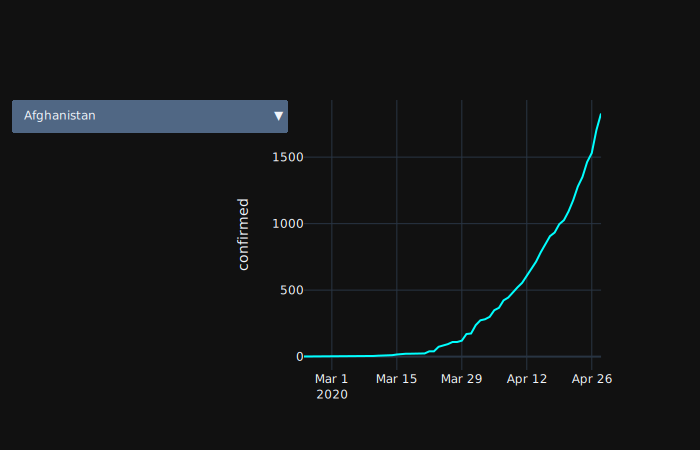

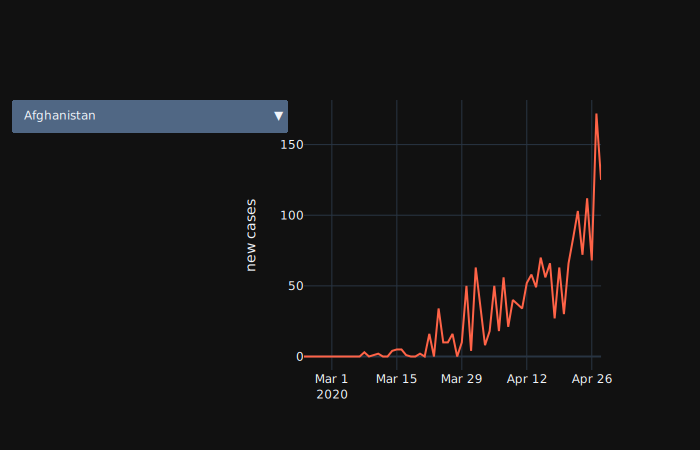

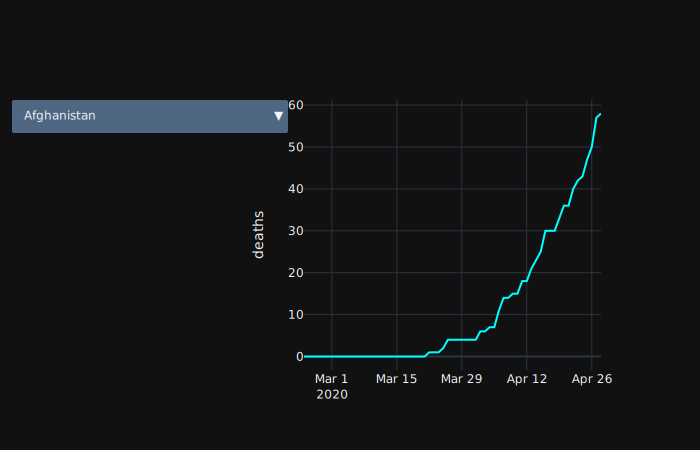

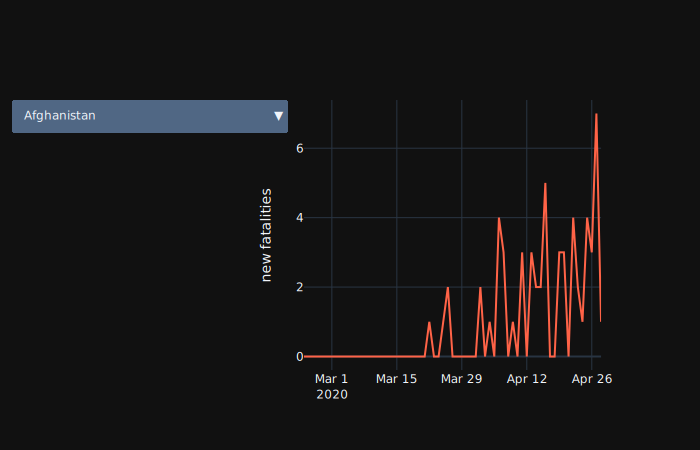

In [25]:
plot_by_country('confirmed')
plot_by_country('new cases')
plot_by_country('deaths')
plot_by_country('new fatalities')

## By State

<b> we have a range of lat and lng for certain states/regions, more precise information</b>

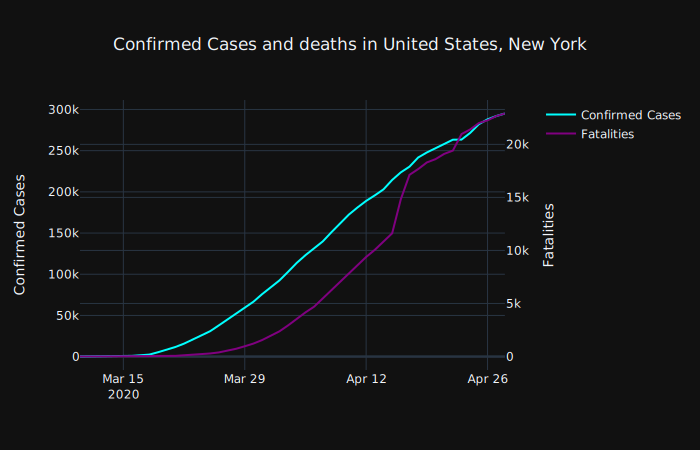

In [26]:
country = 'United States'
state = 'New York'
info_state = df[(df['country_region'] == country) & (df['province_state'] == state)].sort_values(by='date')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=info_state.groupby('date')['date'].first(), y=info_state.groupby('date')['confirmed'].sum(), name='Confirmed Cases', line=dict(color='cyan')))
fig.add_trace(go.Scatter(x=info_state.groupby('date')['date'].first(), y=info_state.groupby('date')['deaths'].sum(), name='Fatalities', line=dict(color='purple')), secondary_y=True)

fig.update_yaxes(title_text="Confirmed Cases", secondary_y=False)
fig.update_yaxes(title_text="Fatalities", secondary_y=True)
fig.update_layout(title_text='Confirmed Cases and deaths in {}, {}'.format(country, state), title_x=0.5)
fig.show('svg')